In [2]:
import gc
import os
import pickle
import jsonlines
import torch
from tqdm import tqdm
from collections import defaultdict
import argparse
from core.models.entailment import EntailmentDeberta
from core.data.data_utils import load_ds_from_json
from rank_eval import eval_beir_rank_result

def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

In [3]:
small_scores = load_pickle_file('output/rerank/all_scores_small.pkl')
small_scores

defaultdict(dict,
            {'trec-covid': {'entropy': {'map': {'MAP@1': 0.00172,
                'MAP@3': 0.00434,
                'MAP@5': 0.00676,
                'MAP@10': 0.01273},
               'precision': {'P@1': 0.68,
                'P@3': 0.63333,
                'P@5': 0.64,
                'P@10': 0.624},
               'ndcg': {'NDCG@1': 0.6,
                'NDCG@3': 0.58061,
                'NDCG@5': 0.58596,
                'NDCG@10': 0.57507},
               'mrr': {'MRR@1': 0.68,
                'MRR@3': 0.77333,
                'MRR@5': 0.77833,
                'MRR@10': 0.785},
               'recall_cap': {'R_cap@1': 0.68,
                'R_cap@3': 0.63333,
                'R_cap@5': 0.632,
                'R_cap@10': 0.624}},
              'rank': {'map': {'MAP@1': 0.00175,
                'MAP@3': 0.0051,
                'MAP@5': 0.00807,
                'MAP@10': 0.01358},
               'precision': {'P@1': 0.72,
                'P@3': 0.72,
              

In [4]:
BEIR_DATASET_NAMES = ["trec-covid", "climate-fever", "dbpedia-entity", "fever", "fiqa", "hotpotqa", "msmarco",  "nfcorpus", "nq", "scidocs", "scifact"]

scores = []
for dataset_name in tqdm(BEIR_DATASET_NAMES):
    print(dataset_name)
    try:
        scores.append({
            'dataset': dataset_name,
            'rank': small_scores[dataset_name]['rank']['ndcg']['NDCG@5'],
            'entropy': small_scores[dataset_name]['entropy']['ndcg']['NDCG@5'],
        })
    except Exception as e:
        print(e)
        print(f"Error in {dataset_name}")
print(f"small_scores: {scores}")

100%|██████████| 11/11 [00:00<00:00, 24155.68it/s]

trec-covid
climate-fever
dbpedia-entity
fever
fiqa
'rank'
Error in fiqa
hotpotqa
msmarco
'rank'
Error in msmarco
nfcorpus
nq
scidocs
scifact
'rank'
Error in scifact
small_scores: [{'dataset': 'trec-covid', 'rank': 0.64957, 'entropy': 0.58596}, {'dataset': 'climate-fever', 'rank': 0.20541, 'entropy': 0.12031}, {'dataset': 'dbpedia-entity', 'rank': 0.42848, 'entropy': 0.38341}, {'dataset': 'fever', 'rank': 0.74253, 'entropy': 0.59013}, {'dataset': 'hotpotqa', 'rank': 0.61693, 'entropy': 0.50787}, {'dataset': 'nfcorpus', 'rank': 0.36366, 'entropy': 0.16534}, {'dataset': 'nq', 'rank': 0.45537, 'entropy': 0.37586}, {'dataset': 'scidocs', 'rank': 0.13779, 'entropy': 0.06905}]


In [ ]:
# table_data = ['Reranker', 'Avg.', 'trec-covid', 'climate-fever', 'dbpedia-entity', 'fever', 'fiqa', 'hotpotqa', 'msmarco',  'nfcorpus', 'nq', 'scidocs', 'scifact']

In [5]:
small_scores.keys()

dict_keys(['trec-covid', 'climate-fever', 'dbpedia-entity', 'fever', 'fiqa', 'hotpotqa', 'msmarco', 'nfcorpus', 'nq', 'scidocs', 'scifact'])

In [13]:
all_metrics = set()
for d in small_scores.values(): # d = {'entropy': {'map': {'MAP@1': 0.00172,
    for  v in d.values(): # v = {'map': {'MAP@1': 0.00172,
        for k1, m in v.items(): # k1=map, m={'MAP@1': 0.00172
            for k2 in m.keys():
                all_metrics.add((k1, k2)) # ('map', 'MAP@1')
all_metrics = sorted(all_metrics)
all_metrics

[('map', 'MAP@1'),
 ('map', 'MAP@10'),
 ('map', 'MAP@3'),
 ('map', 'MAP@5'),
 ('mrr', 'MRR@1'),
 ('mrr', 'MRR@10'),
 ('mrr', 'MRR@3'),
 ('mrr', 'MRR@5'),
 ('ndcg', 'NDCG@1'),
 ('ndcg', 'NDCG@10'),
 ('ndcg', 'NDCG@3'),
 ('ndcg', 'NDCG@5'),
 ('precision', 'P@1'),
 ('precision', 'P@10'),
 ('precision', 'P@3'),
 ('precision', 'P@5'),
 ('recall', 'Recall@1'),
 ('recall', 'Recall@10'),
 ('recall', 'Recall@3'),
 ('recall', 'Recall@5'),
 ('recall_cap', 'R_cap@1'),
 ('recall_cap', 'R_cap@10'),
 ('recall_cap', 'R_cap@3'),
 ('recall_cap', 'R_cap@5')]

In [24]:
# "fiqa", "msmarco", "scifact"
dataset_names = ["trec-covid", "climate-fever", "dbpedia-entity", "fever", "hotpotqa", "nfcorpus", "nq", "scidocs"]
methods = ["rank", "entropy"]
all_metrics = [('map', 'MAP@1'), ('map', 'MAP@10'), ('map', 'MAP@3'), ('map', 'MAP@5'), ('mrr', 'MRR@1'), ('mrr', 'MRR@10'), ('mrr', 'MRR@3'), ('mrr', 'MRR@5'), ('ndcg', 'NDCG@1'), ('ndcg', 'NDCG@10'), ('ndcg', 'NDCG@3'), ('ndcg', 'NDCG@5'), ('precision', 'P@1'), ('precision', 'P@10'), ('precision', 'P@3'), ('precision', 'P@5'), ('recall', 'Recall@1'), ('recall', 'Recall@10'), ('recall', 'Recall@3'), ('recall', 'Recall@5'), ('recall_cap', 'R_cap@1'), ('recall_cap', 'R_cap@10'), ('recall_cap', 'R_cap@3'), ('recall_cap', 'R_cap@5')]

# 利用numpy，将small_scores建立高维数组，[指标][方法][数据集]
import numpy as np
score_array = np.zeros((len(all_metrics), len(methods), len(dataset_names)))
for i, dataset_name in enumerate(dataset_names):
    for j, method in enumerate(methods):
        for k, (metric1, metric2) in enumerate(all_metrics):
            try:
                score_array[k, j, i] = small_scores[dataset_name][method][metric1][metric2]
            except Exception as e:
                pass
                # print(e)
                # print(f"Error in {dataset_name}")
score_array.shape

(24, 2, 8)

In [ ]:
# 将score_array转换为DataFrame，将方法名称和指标名称（all_metrics的第二个元素）作为行列索引，数据集这列取平均值
import pandas as pd
# df = pd.DataFrame(score_array.mean(axis=-1), index=all_metrics, columns=methods)
df = pd.DataFrame(score_array.mean(axis=-1), index=[m[1] for m in all_metrics], columns=methods)
df

,rank,entropy
MAP@1,0.191684,0.119089
MAP@10,0.283008,0.210229
MAP@3,0.253027,0.168263
MAP@5,0.268189,0.183877
MRR@1,0.492081,0.096666
MRR@10,0.587360,0.116039
MRR@3,0.564156,0.112126
MRR@5,0.577111,0.114297
NDCG@1,0.466084,0.307277
NDCG@10,0.454178,0.395793


In [30]:
# 过滤掉不需要的指标，只保留@5结尾的
df[df.index.str.endswith('@5')]

,rank,entropy
MAP@5,0.268189,0.183877
MRR@5,0.577111,0.114297
NDCG@5,0.449968,0.349741
P@5,0.276900,0.238606
Recall@5,0.336065,0.269550
R_cap@5,0.087000,0.079000


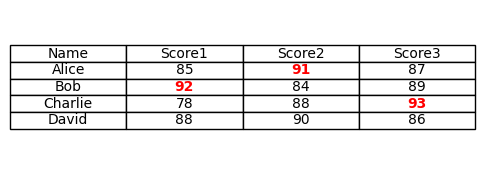

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 示例数据
data = {
    "Name": ["Alice", "Bob", "Charlie", "David"],
    "Score1": [85, 92, 78, 88],
    "Score2": [91, 84, 88, 90],
    "Score3": [87, 89, 93, 86],
}
df = pd.DataFrame(data)

# 找出每列的最大值
max_values = df[["Score1", "Score2", "Score3"]].max()

# 创建一个新的 DataFrame，用于设置加粗格式
def format_bold(val, max_val):
    return f"**{val}**" if val == max_val else f"{val}"

formatted_df = df.copy()
for col in ["Score1", "Score2", "Score3"]:
    formatted_df[col] = df[col].apply(format_bold, max_val=max_values[col])

# 绘制表格
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis("tight")
ax.axis("off")

# 渲染表格
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc="center",
    loc="center",
)

# 加粗最大值的单元格
for i, col in enumerate(["Score1", "Score2", "Score3"], start=1):
    max_row = df[col].idxmax()  # 找到最大值所在行
    cell = table[(max_row + 1, i)]  # 获取对应单元格
    cell.set_text_props(fontweight="bold", color="red")  # 设置加粗和颜色

plt.show()